**WORLD CUP POST SHOT EXPECTED GOALS (PSxG): Avaluation of performance and decision-making of the players**




- Miquel Camí Rodriguez
- Pau Puertas Ametller

In [1]:
pip install statsbombpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 15.4 MB/s eta 0:00:00


In [2]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 25.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from statsbombpy import sb
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Image

Mounted at /content/drive


#Data Extraction

Shots Events

In [4]:
shots_df_2018 = sb.competition_events(country = 'International', division = "FIFA World Cup", season = '2018', gender = 'male', split = True)['shots']
shots_df_2022 = sb.competition_events(country = 'International', division = "FIFA World Cup", season = '2022', gender = 'male', split = True)['shots']
shots_df = pd.concat([shots_df_2018, shots_df_2022])

/usr/local/lib/python3.9/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [5]:
print("Total Shots Events:", len(shots_df))
print('Total Shots Features:', shots_df.shape[1])

Total Shots Events: 3200
Total Shots Features: 39


Goalkeepers Events

In [6]:
gk_df_2018 = sb.competition_events(country = 'International', division = "FIFA World Cup", season = '2018', gender = 'male', split = True)['goal_keepers']
gk_df_2022 = sb.competition_events(country = 'International', division = "FIFA World Cup", season = '2022', gender = 'male', split = True)['goal_keepers']
gk_df = pd.concat([gk_df_2018, gk_df_2022])

In [7]:
gk_df = gk_df [['id', 'player', 'location', 'goalkeeper_position']] #we only take into account the location and position of the goalkepper (we cannot take into account the columns that indicate if the ball has stopped and how when we train the model)
gk_df = gk_df.rename(columns={'id':'gk_id', 'player': 'gk', 'location':'gk_location'})

In [8]:
related_events = list(shots_df['related_events']) #The column related_events is a list with events related to the shot
gk_events = list(gk_df.gk_id) #Events that are on the gk_df
shots_events_gk = [] 
for event in related_events:
  for event_2 in event:
    if event_2 in gk_events:
      shots_events_gk.append(event_2) #Append the related event which refeers to the GK

shots_df['related_events_gk'] = shots_events_gk #save the events related to gk to be able to do the merge action between the 2 datasets

Final Extracted Data

In [9]:
extracted_data = pd.merge(shots_df, gk_df, how='left', left_on=['related_events_gk'], right_on=['gk_id'])
extracted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 0 to 3199
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3200 non-null   object 
 1   index                  3200 non-null   int64  
 2   period                 3200 non-null   int64  
 3   timestamp              3200 non-null   object 
 4   minute                 3200 non-null   int64  
 5   second                 3200 non-null   int64  
 6   type                   3200 non-null   object 
 7   possession             3200 non-null   int64  
 8   possession_team        3200 non-null   object 
 9   play_pattern           3200 non-null   object 
 10  team                   3200 non-null   object 
 11  player                 3200 non-null   object 
 12  position               3200 non-null   object 
 13  location               3200 non-null   object 
 14  duration               3200 non-null   float64
 15  rela

In previous versions of our model, we incorporated Passes, Dribles and Carrys. We considered that are no important to fit our model, because we want it to be generical.

#Data Cleaning

Goal Boolean Variable

In [10]:
bool_goals = extracted_data['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)
extracted_data['goal'] = bool_goals.astype(bool)
extracted_data['goal'].value_counts(dropna = False)

False    2822
True      378
Name: goal, dtype: int64

In [11]:
print("goal Percent 'True':", round((((sum(extracted_data['goal'])) / (len(extracted_data))) * 100), 2), '%')

goal Percent 'True': 11.81 %


Extract Isolated Situations

In [12]:
extracted_data.shot_type.value_counts()

Open Play    2938
Penalty       132
Free Kick     128
Corner          2
Name: shot_type, dtype: int64

In [13]:
extracted_data.shot_body_part.value_counts()

Right Foot    1662
Left Foot      949
Head           562
Other           27
Name: shot_body_part, dtype: int64

In [14]:
#We don't want to have Isolated Situations, as we want a generic Model able to predict Post-Shot XG in common and non-specific situations

cleaned_data = extracted_data[
                              (extracted_data['shot_deflected'] != True) &
                              (extracted_data['shot_redirect'] != True) &
                              (extracted_data['shot_type'] == 'Open Play') #we don't take penalties, free kicks, and corners
                              ]

Extract Unrelated Features

In [15]:
unrelated_features = [
 'type',
 'id',
 'index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'possession_team',
 'team',
 'team_id',
 'player',
 'position',
 'duration',
 'related_events',
 'match_id',
 'shot_statsbomb_xg',
 'shot_outcome',
 'shot_freeze_frame', 
 'under_pressure',
 'possession_team_id',
 'player_id',
 'shot_key_pass_id',
 'shot_aerial_won',
 'shot_open_goal',
 'shot_one_on_one',
 'shot_deflected',
 'shot_redirect',
 'shot_follows_dribble',
 'out',
 'shot_saved_to_post',
 'shot_saved_off_target',
 'related_events_gk',
 'gk_id',
 'gk',
 'play_pattern', 
 'shot_type', 
 'shot_technique', 
 'shot_first_time', 
 'goalkeeper_position']

cleaned_data.drop(unrelated_features, axis = 1, inplace = True)

/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2893 entries, 0 to 3199
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   location           2893 non-null   object
 1   shot_end_location  2893 non-null   object
 2   shot_body_part     2893 non-null   object
 3   gk_location        2893 non-null   object
 4   goal               2893 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 115.8+ KB


In [17]:
cleaned_data.head()

,location,shot_end_location,shot_body_part,gk_location,goal
0,"[98.0, 51.0]","[120.0, 36.2, 4.5]",Right Foot,"[4.0, 41.0]",False
1,"[88.0, 59.0]","[120.0, 46.7, 6.0]",Right Foot,"[1.0, 40.0]",False
2,"[107.0, 48.0]","[120.0, 34.4, 0.3]",Right Foot,"[2.0, 38.0]",False
3,"[82.0, 29.0]","[104.0, 39.0]",Left Foot,"[2.0, 40.0]",False
4,"[106.0, 25.0]","[120.0, 33.9, 0.2]",Head,"[2.0, 43.0]",False


Location Coordinates

In [18]:
# Location
shot_location_df = pd.DataFrame(cleaned_data['location'].tolist(), index = cleaned_data.index)
cleaned_data.drop('location', axis = 1, inplace = True)
cleaned_data['shot_location_x'] = shot_location_df[0]
cleaned_data['shot_location_y'] = shot_location_df[1]

/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-18-b0cd4c416a49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['shot_location_x'] = shot_location_df[0]
<ipython-input-18-b0cd4c416a49>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [19]:
#End Location
end_location_df = pd.DataFrame(cleaned_data['shot_end_location'].tolist(), index = cleaned_data.index)
print('shot_end_location z-coordinate NA:', (sum(end_location_df[2].isna())), '\n', 'Percent shot_end_location z-coordinate NA:', (round((((sum(end_location_df[2].isna())) / (len(cleaned_data))) * 100), 2)), '%')

cleaned_data.drop('shot_end_location', axis = 1, inplace = True)
cleaned_data['end_location_x'] = end_location_df[0]
cleaned_data['end_location_y'] = end_location_df[1]
cleaned_data['end_location_z'] = end_location_df[2]

cleaned_data = cleaned_data.dropna(subset=['end_location_z']) #We delete rows with end_location_z = null. We can't treat these shots.

shot_end_location z-coordinate NA: 1000 
 Percent shot_end_location z-coordinate NA: 34.57 %


<ipython-input-19-9ab88a425114>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['end_location_x'] = end_location_df[0]
<ipython-input-19-9ab88a425114>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['end_location_y'] = end_location_df[1]
<ipython-input-19-9ab88a425114>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [20]:
cleaned_data.end_location_y.describe()

count    1893.00000
mean       40.18711
std         4.61541
min        18.80000
25%        36.70000
50%        40.10000
75%        43.80000
max        60.50000
Name: end_location_y, dtype: float64

In [21]:
#We can see that the minimum (18.8) and the maximum (60.5) are both inside the area.

In [22]:
cleaned_data.end_location_z.describe()

count    1893.000000
mean        2.021500
std         1.891479
min         0.000000
25%         0.500000
50%         1.300000
75%         3.300000
max         7.700000
Name: end_location_z, dtype: float64

In [23]:
cleaned_data['end_location_z'].value_counts() 

0.2    237
0.5    108
0.9     89
0.4     75
1.6     73
      ... 
7.4      3
7.7      2
7.3      2
5.1      2
7.2      1
Name: end_location_z, Length: 78, dtype: int64

In [24]:
(cleaned_data['end_location_z'] < 0.2).sum()

58

In [25]:
#We can see that it sems to be considered that when the ball is going almost on the ground, they consider that is on z=0.2. Max alture 7.7

In [26]:
#Goalkeeper location
gk_location_df = pd.DataFrame(cleaned_data['gk_location'].tolist(), index = cleaned_data.index)
cleaned_data.drop('gk_location', axis = 1, inplace = True)
cleaned_data['gk_location_x'] = gk_location_df[0]
cleaned_data['gk_location_y'] = gk_location_df[1]

<ipython-input-26-44f7c793a43e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['gk_location_x'] = gk_location_df[0]
<ipython-input-26-44f7c793a43e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['gk_location_y'] = gk_location_df[1]


In [27]:
#Delete shots when shot_location_x and end_location_x are equal.
cleaned_data.drop(cleaned_data[cleaned_data['shot_location_x'] == cleaned_data['end_location_x']].index, inplace=True)

In [28]:
cleaned_data.head()

,shot_body_part,goal,shot_location_x,shot_location_y,end_location_x,end_location_y,end_location_z,gk_location_x,gk_location_y
0,Right Foot,False,98.0,51.0,120.0,36.2,4.5,4.0,41.0
1,Right Foot,False,88.0,59.0,120.0,46.7,6.0,1.0,40.0
2,Right Foot,False,107.0,48.0,120.0,34.4,0.3,2.0,38.0
4,Head,False,106.0,25.0,120.0,33.9,0.2,2.0,43.0
6,Left Foot,False,97.0,20.0,120.0,45.6,0.2,4.0,45.0


#Feature Engine

Let's first see how are our pitch dimensions

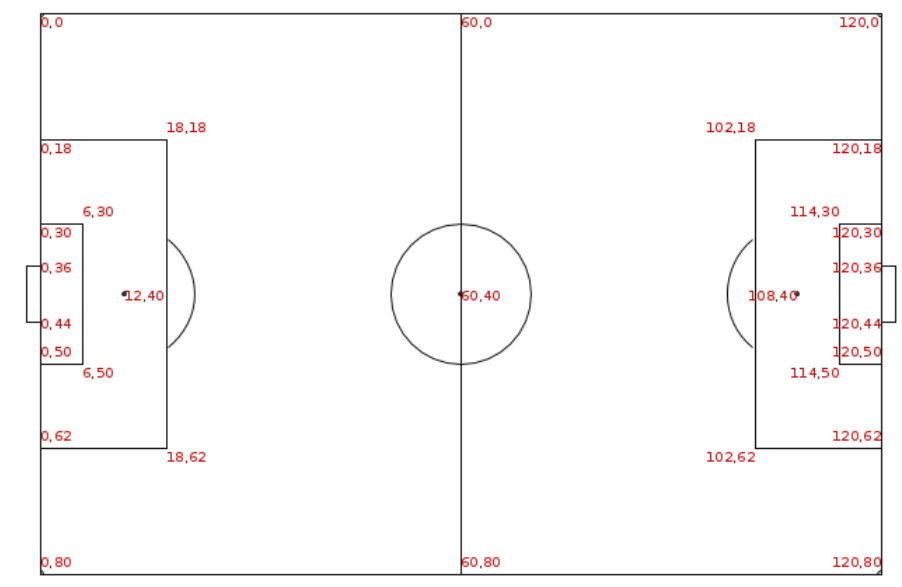

In [29]:
Image('/content/drive/My Drive/SPORTSANALYTICS/PROYECTO/assets/pitch_dim.png')

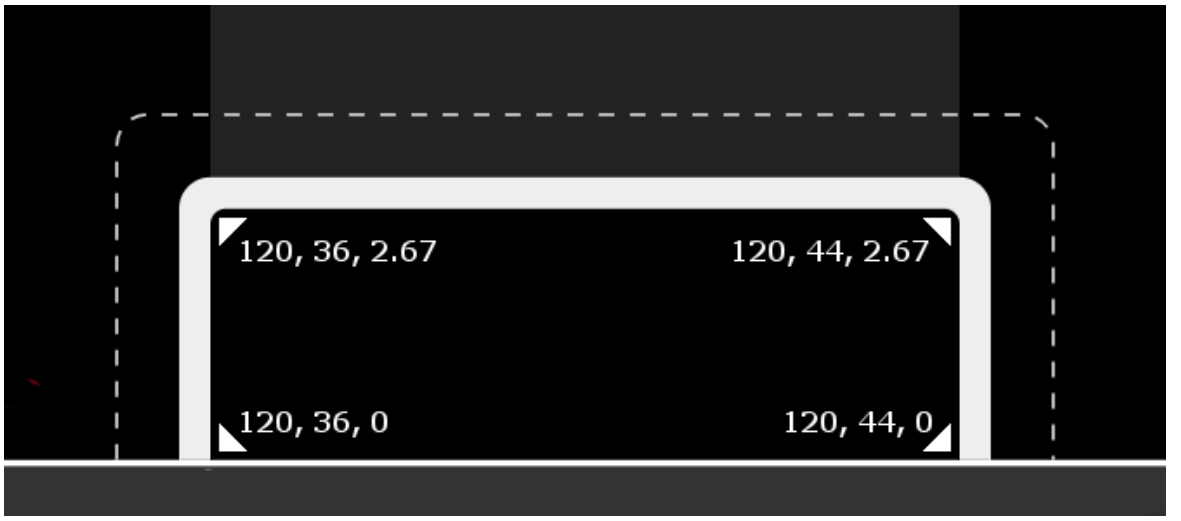

In [30]:
Image('/content/drive/My Drive/SPORTSANALYTICS/PROYECTO/assets/goal_dim.png')

In [31]:
pitch_dim = np.array([120,80])

Distance to Goal

In [32]:
def distance_to_goal(shot_location):
    opp_goal_pos = np.array([1,0.5]) * pitch_dim #this is the opponent goal location
    
    return np.linalg.norm(opp_goal_pos - shot_location)

cleaned_data['distance_to_goal'] = cleaned_data.apply(lambda row: distance_to_goal(np.array([row.shot_location_x, row.shot_location_y])), axis=1).round(1)

Angle to Goal

In [33]:
def angle_to_goal(shot_location):

    v1 = np.array([120, 36]) - shot_location
    v2 = np.array([120, 44]) - shot_location
    
    cosang = np.dot(v1, v2)
    sinang = np.linalg.norm(np.cross(v1, v2))
    
    return np.arctan2(sinang, cosang)

cleaned_data['angle_to_goal'] = cleaned_data.apply(lambda row: angle_to_goal(np.array([row.shot_location_x, row.shot_location_y])), axis=1).round(1)

In [34]:
angle_to_goal(np.array([110, 70])).round(1)

0.1

Distance to Goalkeeper

In [35]:
def distance_to_gk(shot_location, gk_pos):    
    return np.linalg.norm(gk_pos - shot_location)
#the gk coordinate has to be 120-position_x because is taked in the other way
cleaned_data['distance_to_gk'] = cleaned_data.apply(lambda row: distance_to_gk(np.array([(120-row.gk_location_x), row.gk_location_y]),np.array([row.shot_location_x, row.shot_location_y])), axis=1).round(1) 

In [36]:
cleaned_data.gk_location_x.describe()

count    1888.000000
mean        2.778655
std         2.392090
min         0.100000
25%         1.700000
50%         2.100000
75%         3.000000
max        59.000000
Name: gk_location_x, dtype: float64

Extrapolate End Location to the goal line

In [38]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1888 entries, 0 to 3199
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shot_body_part    1888 non-null   object 
 1   goal              1888 non-null   bool   
 2   shot_location_x   1888 non-null   float64
 3   shot_location_y   1888 non-null   float64
 4   end_location_x    1888 non-null   float64
 5   end_location_y    1888 non-null   float64
 6   end_location_z    1888 non-null   float64
 7   gk_location_x     1888 non-null   float64
 8   gk_location_y     1888 non-null   float64
 9   distance_to_goal  1888 non-null   float64
 10  angle_to_goal     1888 non-null   float64
 11  distance_to_gk    1888 non-null   float64
dtypes: bool(1), float64(10), object(1)
memory usage: 178.8+ KB


In [39]:
# Define the two points
p1 = np.array([93.8, 56.8, 0.0])
p2 = np.array([118.7, 43.7, 0.3])

# Find the direction vector of the line
v = p2 - p1

# Find the equation of the line in parametric form
# x = x1 + t*v_x
# y = y1 + t*v_y
# z = z1 + t*v_z
# where (x1, y1, z1) is the first point and (v_x, v_y, v_z) is the direction vector
# t is a parameter that can take any real value
def line_equation(t):
    return p1 + t*v

# Find the value of t that corresponds to x=120.0
t = (120.0 - p1[0])/v[0]

# Find the corresponding values of y and z
y2, z2 = line_equation(t)[1], line_equation(t)[2]

In [40]:
def correct_rare_values(y2, z2):
  if y2<18: #when the area starts
    y2=18
  elif y2>62: #when the area finish
    y2=62
  if z2<0.2:
    z2=0.2
  elif z2>8: #we consider that the ball can go maxim 8 meters above the goal to group this thype of shots
    z2=8
  return [y2, z2]

In [41]:
#Correct End location with Extrapolation
#We want to know the end location when the ball is on the goal line.

def extrapolate_end_loc(x0, y0, x1, y1, z1, body_part):
  x2 = 120.0 #Goal line 
  if x1<120.0:
    if body_part == 'Head':
      z0=1.78 #mean height soccer players
    else:
      z0=0.0 #the ball starts on the floor
    p0 = np.array([x0, y0, z0])
    p1 = np.array([x1, y1, z1])
    v = p1 - p0
    t = (120.0 - p0[0])/v[0]
    y2 = (p0 + t*v)[1]
    z2 = (p0 + t*v)[2]

    y2, z2 = correct_rare_values(y2, z2)
    return [round(x2,2), round(y2,2), round(z2,2)]
  else: 
    return [x1, y1, z1]

cleaned_data['proj_end_location'] = cleaned_data.apply(lambda row: extrapolate_end_loc(row.shot_location_x, row.shot_location_y, row.end_location_x,row.end_location_y,row.end_location_z, row.shot_body_part), axis=1)

In [42]:
proj_end_location_df = pd.DataFrame(cleaned_data['proj_end_location'].tolist(), index = cleaned_data.index)
cleaned_data.drop('proj_end_location', axis = 1, inplace = True)
#cleaned_data['proj_end_location_x'] = proj_end_location_df[0]
cleaned_data['proj_end_location_y'] = proj_end_location_df[1]
cleaned_data['proj_end_location_z'] = proj_end_location_df[2]

In [43]:
cleaned_data['proj_end_location_z'].describe()

count    1888.000000
mean        2.126531
std         1.911620
min         0.000000
25%         0.500000
50%         1.535000
75%         3.500000
max         8.000000
Name: proj_end_location_z, dtype: float64

In [44]:
cleaned_data = cleaned_data.drop(['shot_body_part', 'end_location_x', 'end_location_y', 'end_location_z'], axis = 1) #We remove shot body part and ends_positions

In [45]:
cleaned_data.head()

,goal,shot_location_x,shot_location_y,gk_location_x,gk_location_y,distance_to_goal,angle_to_goal,distance_to_gk,proj_end_location_y,proj_end_location_z
0,False,98.0,51.0,4.0,41.0,24.6,0.3,20.6,36.2,4.5
1,False,88.0,59.0,1.0,40.0,37.2,0.2,36.4,46.7,6.0
2,False,107.0,48.0,2.0,38.0,15.3,0.4,14.9,34.4,0.3
4,False,106.0,25.0,2.0,43.0,20.5,0.3,21.6,33.9,0.2
6,False,97.0,20.0,4.0,45.0,30.5,0.2,31.4,45.6,0.2


#Data Exploration

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid', context = 'talk')

def num_feature_v_goal(feature,
                       xlabel, data):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.set_palette(sns.color_palette(['plum', 'purple']))
    sns.histplot(data = data,
                 ax = ax,
                 multiple = 'stack',
                 x = feature,
                 hue = 'goal',
                 element = 'bars')
    ax.set_title('Goals v Shots by ' + xlabel)
    ax.set_xlabel(xlabel)
    ax.legend(labels = ['Goal',
                        'Miss'],
              bbox_to_anchor = (1.05, 1),
              loc = 2,
              borderaxespad = 0);


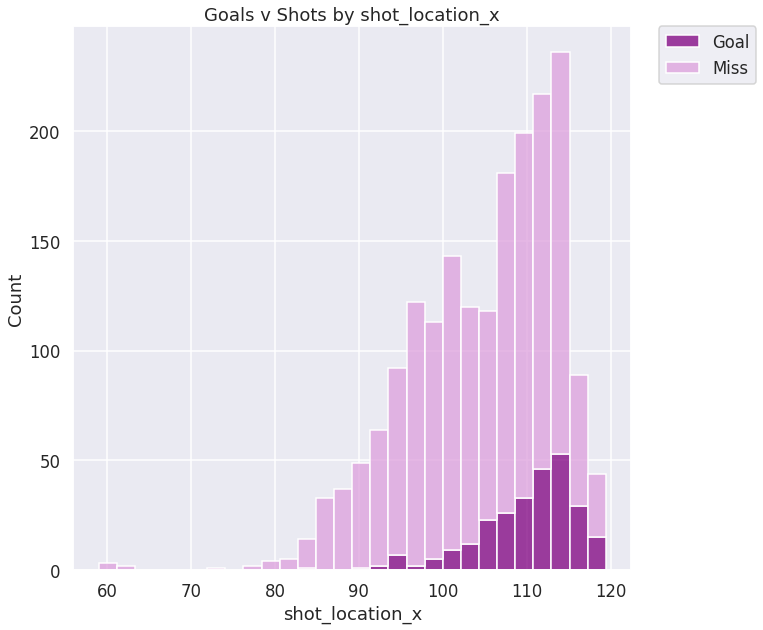

In [47]:
num_feature_v_goal('shot_location_x',
                   'shot_location_x', cleaned_data)

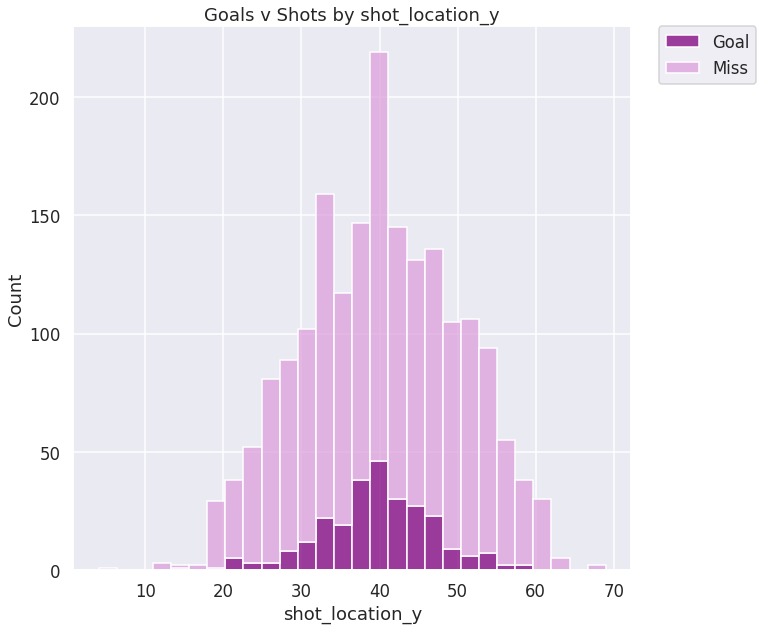

In [48]:
num_feature_v_goal('shot_location_y',
                   'shot_location_y', cleaned_data)

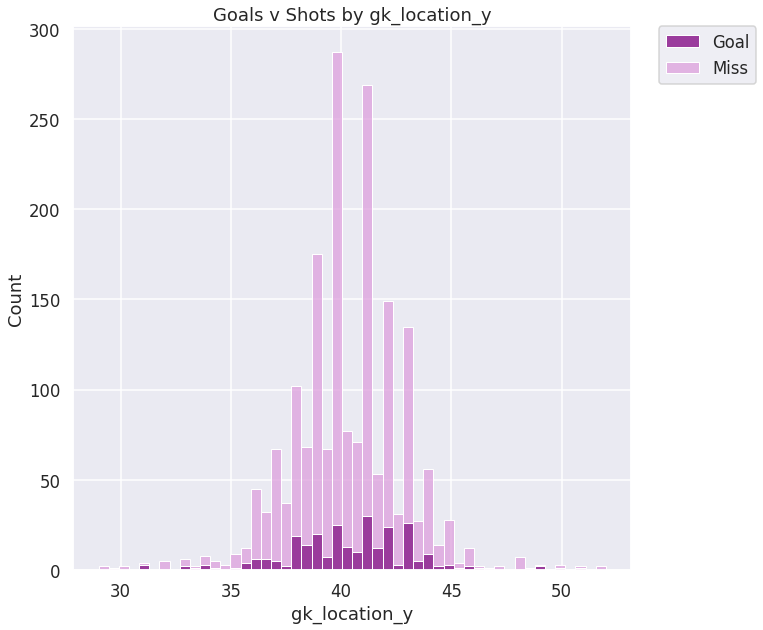

In [49]:
num_feature_v_goal('gk_location_y',
                   'gk_location_y', cleaned_data)

In [50]:
cleaned_data.gk_location_y.describe()

count    1888.000000
mean       40.279873
std         2.534880
min        29.000000
25%        39.000000
50%        40.100000
75%        41.900000
max        52.000000
Name: gk_location_y, dtype: float64

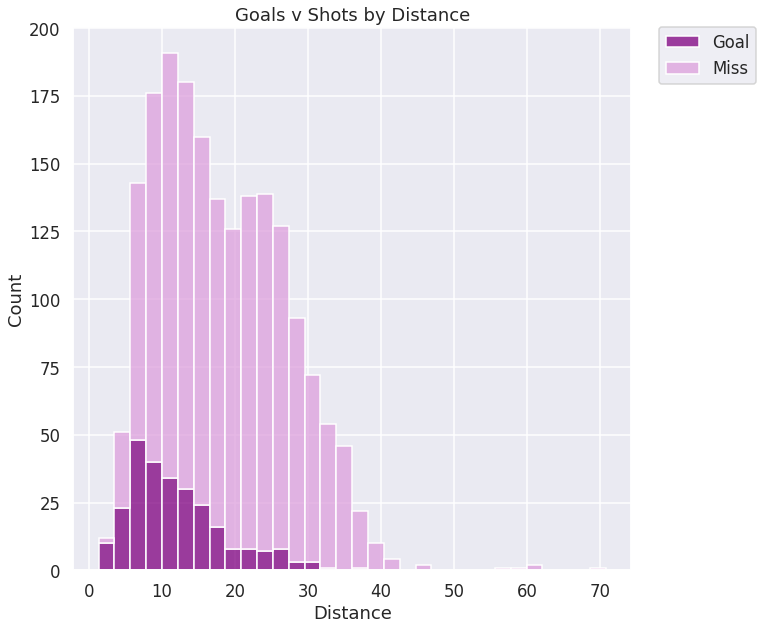

In [51]:
num_feature_v_goal('distance_to_goal',
                   'Distance', cleaned_data)

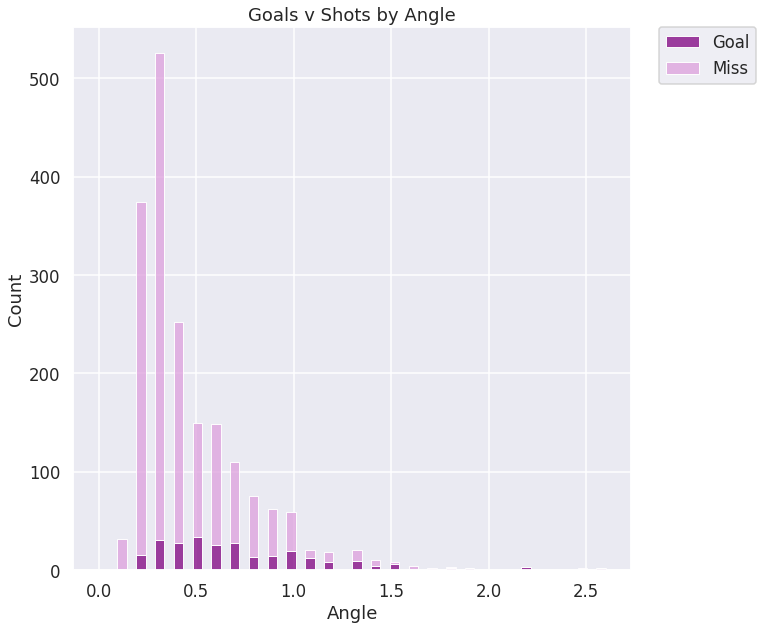

In [52]:
num_feature_v_goal('angle_to_goal',
                   'Angle', cleaned_data)

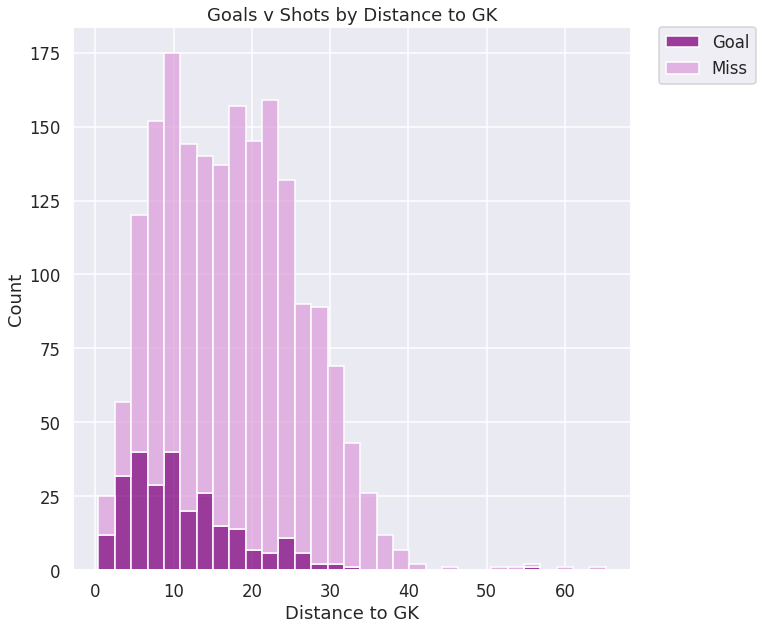

In [53]:
num_feature_v_goal('distance_to_gk',
                   'Distance to GK', cleaned_data)

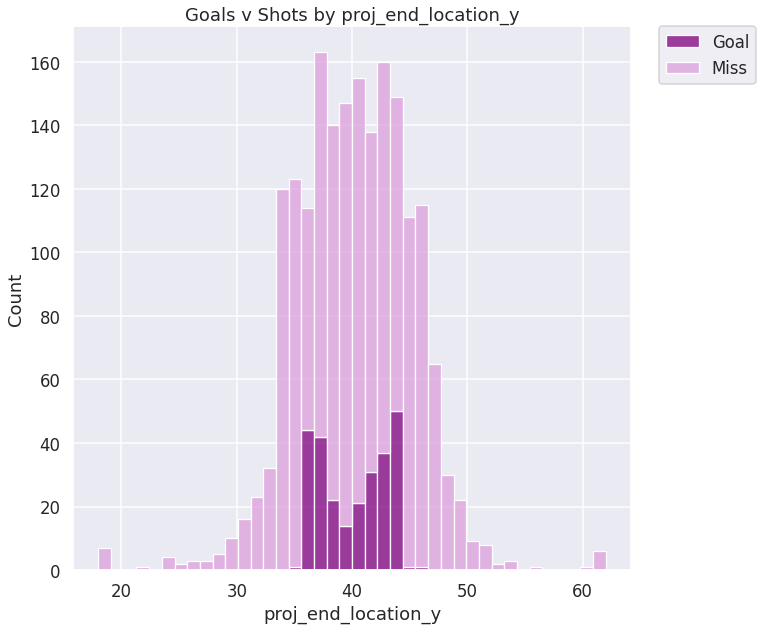

In [54]:
num_feature_v_goal('proj_end_location_y',
                   'proj_end_location_y', cleaned_data)

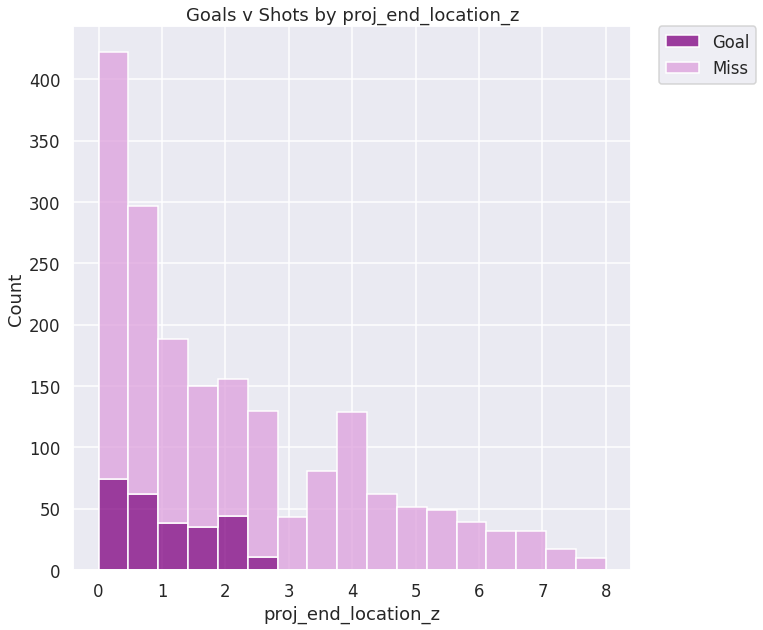

In [55]:
num_feature_v_goal('proj_end_location_z',
                   'proj_end_location_z', cleaned_data)

#Data Modeling

In [56]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.calibration import calibration_curve

##Data Preprocessing

In [57]:
X = cleaned_data.drop(['goal', 
                       'shot_location_x', #we don't need it as we have the distance with the goal
                       'gk_location_x'
                       ], axis = 1)
y = cleaned_data['goal']
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 13)

X_test_df = X_test.copy() #To use later on the player and team evaluation

In [58]:
scaler = StandardScaler()
scaler.fit(X_train) #We fit it with X_train

X_train = scaler.transform(X_train) #Scale our X_train
X_test = scaler.transform(X_test) #Scale our X_test

y_train.value_counts()

False    1218
True      198
Name: goal, dtype: int64

Class Imbalance

In [59]:
#We can use oversample to the class which is the minority, in this case Goal=True
sm = SMOTE(random_state = 13)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)

In [60]:
y_train_os.value_counts()

False    1218
True     1218
Name: goal, dtype: int64

## Evaluation Metrics

Evaluation Metrics

-	Recall is a measure of how well our model is able to identify all positive examples (goals) in the dataset. Specifically, it is the ratio of the true positive predictions (goals correctly identified) to the total number of actual positive examples (all goals in the dataset). A high recall means that our model is able to correctly identify most of the positive examples in the dataset.
-	ROC (Receiver Operating Characteristic) is a plot of the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds. The area under the ROC curve (AUC-ROC) is a measure of how well our model is able to distinguish between positive and negative examples. A higher AUC-ROC means that our model is better able to discriminate between positive and negative examples.
-	Accuracy is the proportion of correctly classified examples (both positives and negatives) to the total number of examples. It is a measure of overall performance of the model.
-	F1-score is the harmonic mean of precision and recall and, is a measure of the balance between precision (the proportion of predicted positives that are actually positive) and recall (the proportion of actual positives that are correctly predicted). A high F1-score means that our model has a good balance between precision and recall.


In [61]:
def model_report(y,
                 y_prediction):
  report = pd.DataFrame(classification_report(y,
                                              y_prediction,
                                              output_dict = True))
  display(report)

def model_roc(train, test, train_probability, test_probability, ax):
    print('Train - Area Under the Curve:', round(roc_auc_score(train, train_probability[:,1]),2))
    print('Test - Area Under the Curve:', round(roc_auc_score(test, test_probability[:,1]),2))

    fpr_train, tpr_train, thresholds_train = roc_curve(train, train_probability[:,1])
    fpr_test, tpr_test, thresholds_test = roc_curve(test, test_probability[:,1])

    ax.plot(fpr_train, tpr_train, 'aqua', label='Train')
    ax.plot(fpr_test, tpr_test, 'lightcoral', label='Test')
    ax.plot([0, 1], [0, 1], 'purple')

    ax.set_title('Receiver Operating Characteristic')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);

def model_cal_curve(y_test, y_pred, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    x, y = calibration_curve(y_test, y_pred[:,1], n_bins = 15, normalize = True)
    ax.plot([0, 1], [0, 1], 'r--', label = 'Ideally Calibrated')
    ax.plot(y, x, marker = '.', color='b', label = 'Model')
    ax.plot([])
    leg = ax.legend(loc = 'upper left')
    ax.set_xlabel('Average Predicted Probability in each bin')
    ax.set_ylabel('Ratio of positives')
    ax.set_title('Calibration Curve')
    plt.show()

def model_f1_score(y_test, y_pred):
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('f1-score of the model_',f1)

def evaluate_model(y_train, y_train_pred, y_test, y_test_pred, train_prob, test_prob):
    # Model Report
    print("Model Report Train:")
    model_report(y_train, y_train_pred)
    print("Model Report Test:")
    model_report(y_test, y_test_pred)

    # ROC Curve
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_title('Test ROC Curve')
    model_roc(y_train, y_test, train_prob, test_prob, ax=ax)

    plt.tight_layout()
    plt.show()

    # Calibration Curve
    print("Calibration Curve:")
    fig, ax = plt.subplots(figsize = (10, 10))
    model_cal_curve(y_test, test_prob, ax=ax)

    # F1 Score
    print("F1 Score:")
    model_f1_score(y_test, y_test_pred)

##Models

In [62]:
def model_grid(model, params):
    grid = GridSearchCV(model,
                        params,
                        refit = True,
                        cv = 5)
    
    grid.fit(X_train_os, y_train_os)

    grid_best = grid.best_params_

    display(grid_best)

### Decision Tree

In [63]:
dt = DecisionTreeClassifier(random_state = 13,
                            class_weight = 'balanced')

dt_params = {'criterion' : ['gini', 'entropy'],
            'max_depth' : [1, 5, 10],
            'min_samples_split' : [1, 5, 10],
            'min_samples_leaf' : [1, 5]}

model_grid(dt, dt_params)

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 1}

In [64]:
dt_best = DecisionTreeClassifier(criterion = 'gini',
                                 class_weight = 'balanced',
                                 random_state = 13,
                                 min_samples_split = 10,
                                 min_samples_leaf = 1)

dt_params = {'max_depth' : [10, 20, 50, 100]}

# Use Grid Search to find the best parameters for dt

model_grid(dt, dt_params)

{'max_depth': 20}

Model Report Train:


,False,True,accuracy,macro avg,weighted avg
precision,0.912446,0.878049,0.894499,0.895248,0.895248
recall,0.872742,0.916256,0.894499,0.894499,0.894499
f1-score,0.892153,0.896746,0.894499,0.894449,0.894449
support,1218.000000,1218.000000,0.894499,2436.000000,2436.000000


Model Report Test:


,False,True,accuracy,macro avg,weighted avg
precision,0.949296,0.410256,0.815678,0.679776,0.873922
recall,0.830049,0.727273,0.815678,0.778661,0.815678
f1-score,0.885677,0.524590,0.815678,0.705133,0.835186
support,406.000000,66.000000,0.815678,472.000000,472.000000


Train - Area Under the Curve: 0.95
Test - Area Under the Curve: 0.85


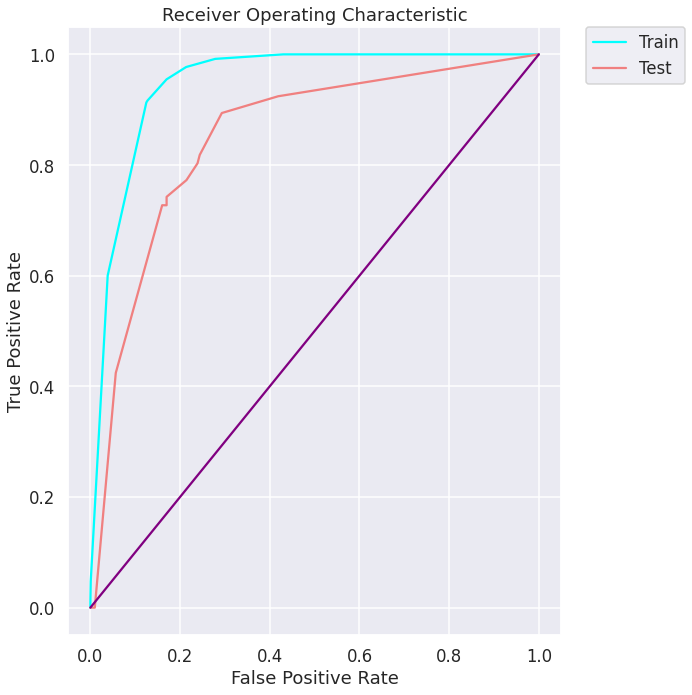

Calibration Curve:


/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


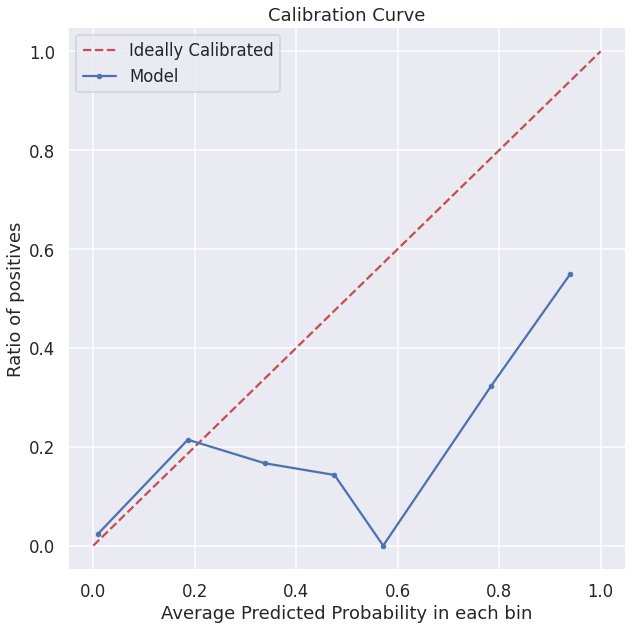

F1 Score:
f1-score of the model_ 0.8351858214374777


In [65]:
dt_best = DecisionTreeClassifier(criterion = 'gini',
                                 class_weight = 'balanced',
                                 max_depth = 5,
                                 random_state = 13,
                                 min_samples_split = 1,
                                 min_samples_leaf = 1)

dt_best.fit(X_train_os,
            y_train_os)

dt_train_predict = dt_best.predict(X_train_os)
dt_train_probability = dt_best.predict_proba(X_train_os)

dt_test_predict = dt_best.predict(X_test)
dt_test_probability = dt_best.predict_proba(X_test)

evaluate_model(y_train_os, dt_train_predict, y_test, dt_test_predict, dt_train_probability, dt_test_probability)

### Random Forest

In [66]:
rf = RandomForestClassifier(random_state = 13,
                            class_weight = 'balanced')

rf_params = {'n_estimators' : [100, 150, 200],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 50, 100],
             'min_samples_split' : [2, 5, 10],
             'min_samples_leaf' : [1, 5]}

# Use Grid Search to find the best parameters for rf

model_grid(rf, rf_params)

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [67]:
rf_best = RandomForestClassifier(criterion = 'gini',
                                 min_samples_leaf = 1,
                                 min_samples_split = 5,
                                 max_depth = 50,
                                 random_state = 13,
                                 class_weight = 'balanced')

rf_params = {'n_estimators' : [75, 100, 125, 150]}

# Use Grid Search to find the best parameters for rf

model_grid(rf, rf_params)

{'n_estimators': 100}

Model Report Train:


,False,True,accuracy,macro avg,weighted avg
precision,0.998361,1.000000,0.999179,0.999180,0.999180
recall,1.000000,0.998358,0.999179,0.999179,0.999179
f1-score,0.999180,0.999178,0.999179,0.999179,0.999179
support,1218.000000,1218.000000,0.999179,2436.000000,2436.000000


Model Report Test:


,False,True,accuracy,macro avg,weighted avg
precision,0.950649,0.540230,0.875,0.745440,0.893260
recall,0.901478,0.712121,0.875,0.806800,0.875000
f1-score,0.925411,0.614379,0.875,0.769895,0.881919
support,406.000000,66.000000,0.875,472.000000,472.000000


Train - Area Under the Curve: 1.0
Test - Area Under the Curve: 0.93


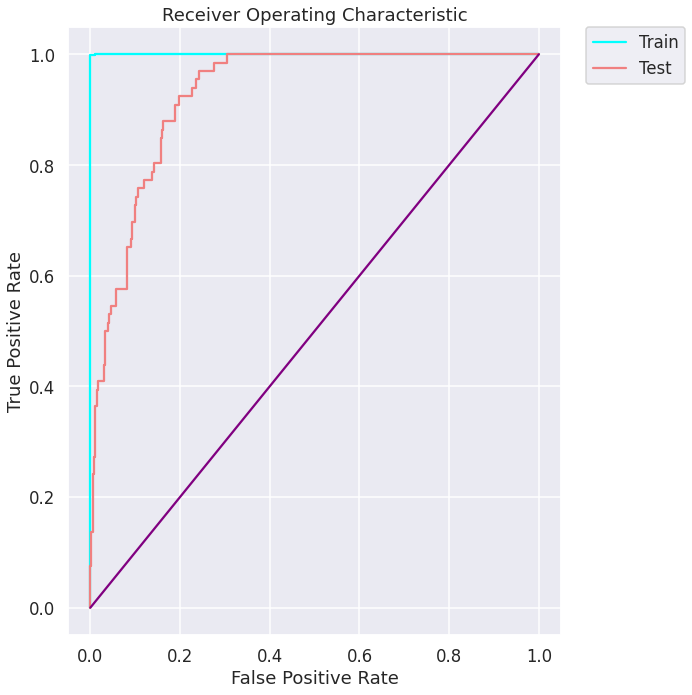

Calibration Curve:


/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


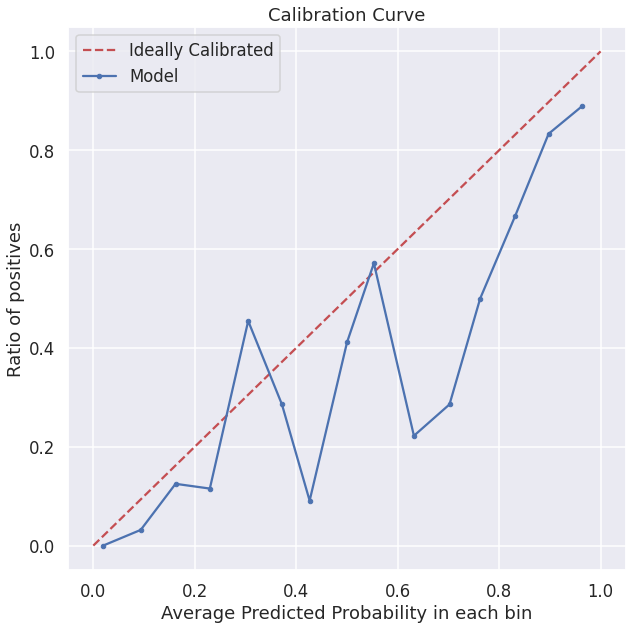

F1 Score:
f1-score of the model_ 0.8819191393371509


In [68]:
rf_best = RandomForestClassifier(n_estimators = 100,
                                 criterion = 'entropy',
                                 min_samples_leaf = 1,
                                 min_samples_split = 5,
                                 max_depth = 50,
                                 random_state = 13,
                                 class_weight = 'balanced')

rf_best.fit(X_train_os,
            y_train_os)

rf_train_predict = rf_best.predict(X_train_os)
rf_train_probability = rf_best.predict_proba(X_train_os)

rf_test_predict = rf_best.predict(X_test)
rf_test_probability = rf_best.predict_proba(X_test)

evaluate_model(y_train_os, rf_train_predict, y_test, rf_test_predict, rf_train_probability, rf_test_probability)

### Gradient Boost

In [69]:
gb = GradientBoostingClassifier(random_state = 13)

gb_params = {'n_estimators' : [50, 100, 150],
             'learning_rate' : [0.01, 0.1, 1]}

model_grid(gb, gb_params)

{'learning_rate': 1, 'n_estimators': 150}

Model Report Train:


,False,True,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,1218.0,1218.0,1.0,2436.0,2436.0


Model Report Test:


,False,True,accuracy,macro avg,weighted avg
precision,0.946154,0.548780,0.877119,0.747467,0.890589
recall,0.908867,0.681818,0.877119,0.795343,0.877119
f1-score,0.927136,0.608108,0.877119,0.767622,0.882526
support,406.000000,66.000000,0.877119,472.000000,472.000000


Train - Area Under the Curve: 1.0
Test - Area Under the Curve: 0.93


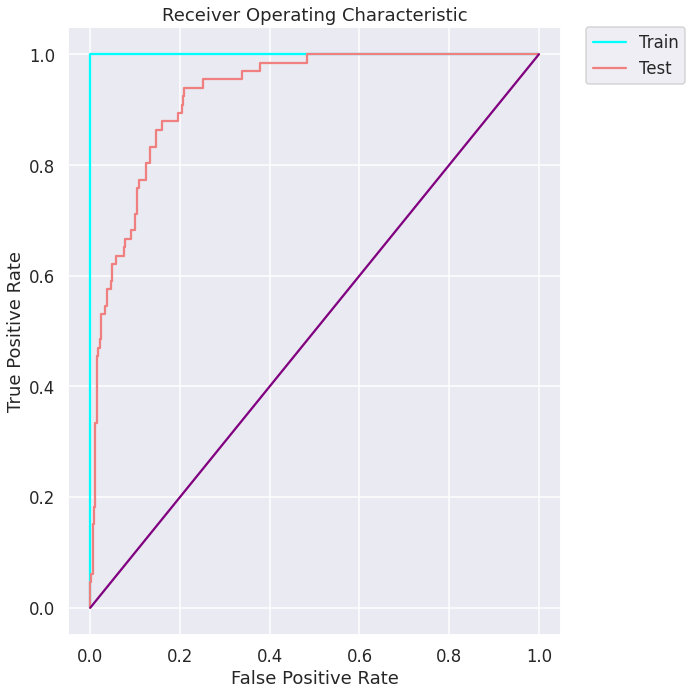

Calibration Curve:


/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


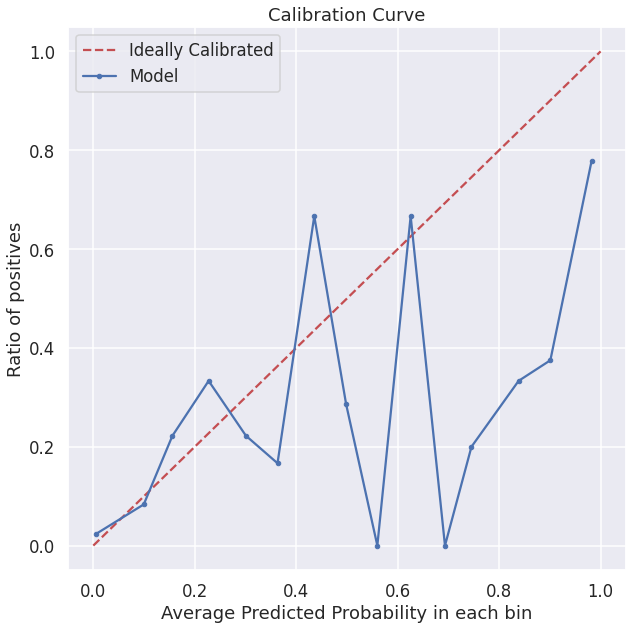

F1 Score:
f1-score of the model_ 0.8825258910217602


In [70]:
gb_best = GradientBoostingClassifier(random_state = 13,
                                     n_estimators = 150,
                                     learning_rate = 0.4)

gb_best.fit(X_train_os,
            y_train_os)

gb_train_predict = gb_best.predict(X_train_os)
gb_train_probability = gb_best.predict_proba(X_train_os)

gb_test_predict = gb_best.predict(X_test)
gb_test_probability = gb_best.predict_proba(X_test)

evaluate_model(y_train_os, gb_train_predict, y_test, gb_test_predict, gb_train_probability, gb_test_probability)

### XG Boost

In [71]:
xgb1 = xgb.XGBClassifier()

xgb_params = {'eta' : [0.05, 0.1, 0.15],
             'max_depth' : [5, 10, 15],
             'subsample' : [0.5, 1],
             'objective' : ['binary:logistic', 'binary:logitraw', 'binary:hinge']}

model_grid(xgb1, xgb_params)

{'eta': 0.15, 'max_depth': 15, 'objective': 'binary:logitraw', 'subsample': 1}

Model Report Train:


,False,True,accuracy,macro avg,weighted avg
precision,0.983498,0.978758,0.981117,0.981128,0.981128
recall,0.978654,0.983580,0.981117,0.981117,0.981117
f1-score,0.981070,0.981163,0.981117,0.981116,0.981116
support,1218.000000,1218.000000,0.981117,2436.000000,2436.000000


Model Report Test:


,False,True,accuracy,macro avg,weighted avg
precision,0.956186,0.583333,0.889831,0.769759,0.904049
recall,0.913793,0.742424,0.889831,0.828109,0.889831
f1-score,0.934509,0.653333,0.889831,0.793921,0.895192
support,406.000000,66.000000,0.889831,472.000000,472.000000


Train - Area Under the Curve: 1.0
Test - Area Under the Curve: 0.93


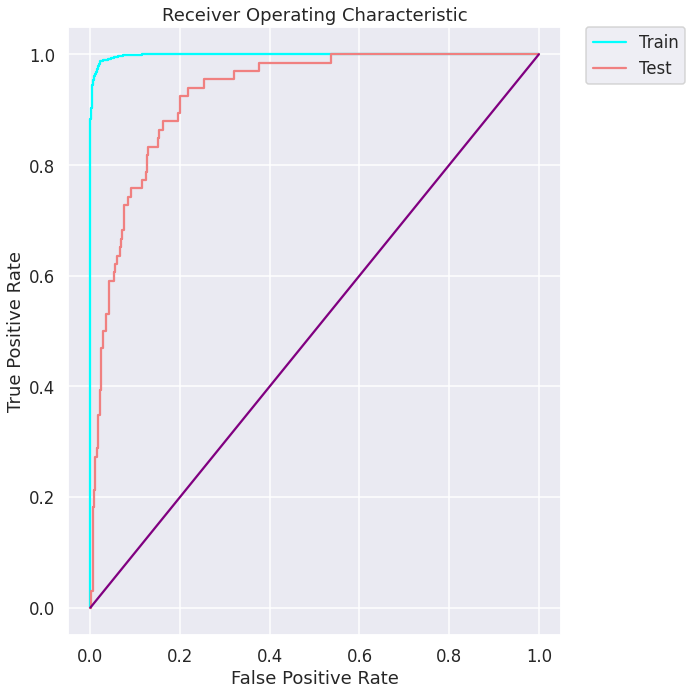

Calibration Curve:


/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


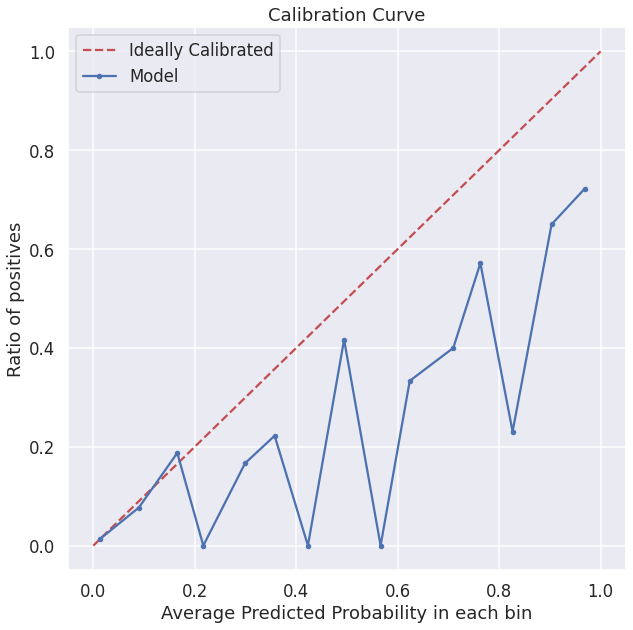

F1 Score:
f1-score of the model_ 0.895191905392136


In [72]:
xgb_best = xgb.XGBClassifier(eta = 0.05,
                             max_depth = 9,
                             objective = 'binary:logitraw',
                             subsample = 0.5)

xgb_best.fit(X_train_os,
             y_train_os)

xgb_train_predict = xgb_best.predict(X_train_os)
xgb_train_probability = xgb_best.predict_proba(X_train_os)

xgb_test_predict = xgb_best.predict(X_test)
#xgb_test_probability = xgb_best.predict_proba(X_test) #if we use 'binary:logistic'
xgb_test_probability = 1 / (1 + np.exp(-xgb_best.predict_proba(X_test))) #we need to use sigmoid when using 'binary:logitraw'

evaluate_model(y_train_os, xgb_train_predict, y_test, xgb_test_predict, xgb_train_probability, xgb_test_probability)

## Compare Models

In [73]:
model_names = [  'Decision Tree',
                 'Random Forest',
                 'Gradient Boost',
                 'XG Boost']

model_comparison = pd.DataFrame(model_names, columns = ['Model'])


probabilities = [
                 dt_test_probability,
                 rf_test_probability,
                 gb_test_probability,
                 xgb_test_probability]

predictions = [
                 dt_test_predict,
                 rf_test_predict,
                 gb_test_predict,
                 xgb_test_predict]

recall_scores = []
for p in predictions:
    recall_scores.append(round((recall_score(y_test, p)), 2))

model_comparison['Recall'] = recall_scores

roc_scores = []
for p in probabilities:
    roc_scores.append(round((roc_auc_score(y_test, p[:,1])), 2))

model_comparison['ROC'] = roc_scores

accuracy_scores = []
for p in predictions:
    accuracy_scores.append(round((accuracy_score(y_test, p)), 2))

model_comparison['Accuracy'] = accuracy_scores

f1_scores = []
for p in predictions:
    f1_scores.append(round((f1_score(y_test, p, average='weighted')), 2))

model_comparison['f1-Score'] = f1_scores

model_comparison.sort_values('f1-Score',
                             ascending = False,
                             inplace = True)

model_comparison

,Model,Recall,ROC,Accuracy,f1-Score
3,XG Boost,0.74,0.93,0.89,0.90
1,Random Forest,0.71,0.93,0.88,0.88
2,Gradient Boost,0.68,0.93,0.88,0.88
0,Decision Tree,0.73,0.85,0.82,0.84


#Feature Selection

In [74]:
def model_fi(model):
    model.fit(X_train_os, y_train_os)
    predictions = model.predict(X_test)
    
    fi = (pd.DataFrame(model.feature_importances_,
                       index = X.columns, 
          columns = ['importance']).sort_values('importance',
                                                ascending = False))
    fig, ax = plt.subplots(figsize = (10, 20))
    sns.barplot(x = 'importance', y = fi.index, 
                data = fi, color = 'purple')
    ax.set_title('Feature Importance')
    plt.show()

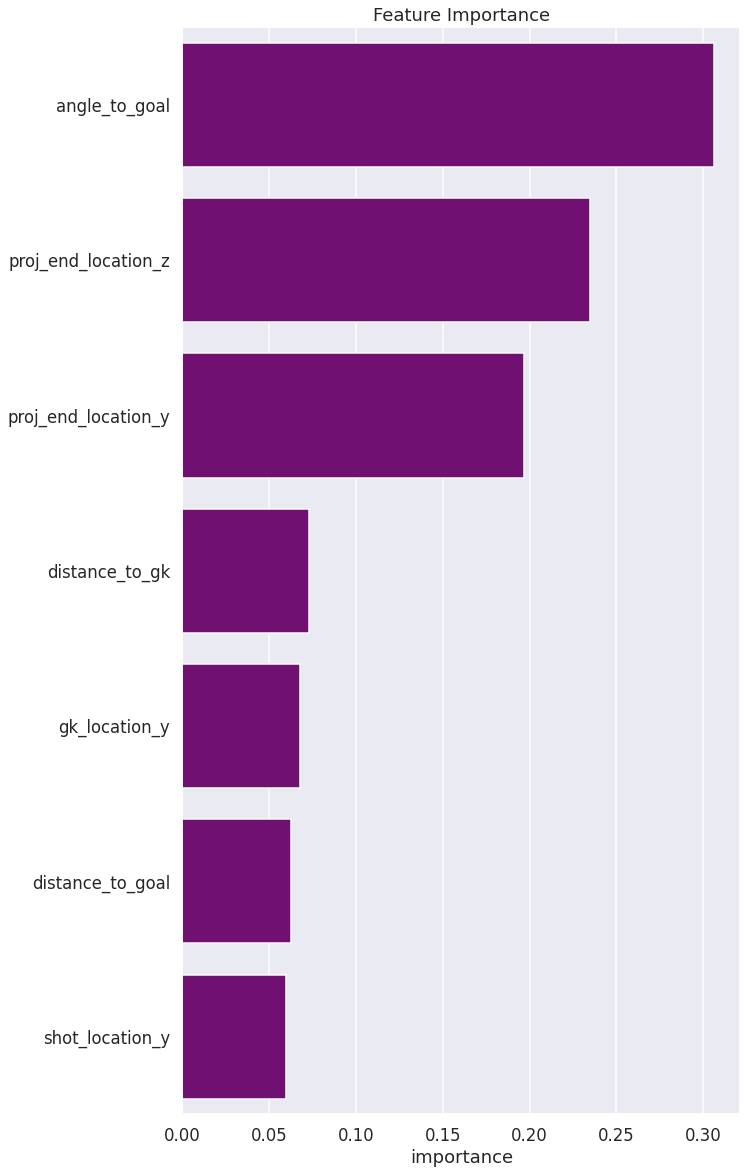

In [75]:
model_fi(xgb_best)

- We can clearly see how the two end_position variables and the angle_to_goal variable are by far the most important for the model.
- Even so, none of the others seems to be expendable since they all contribute more than 0.07 of importance.


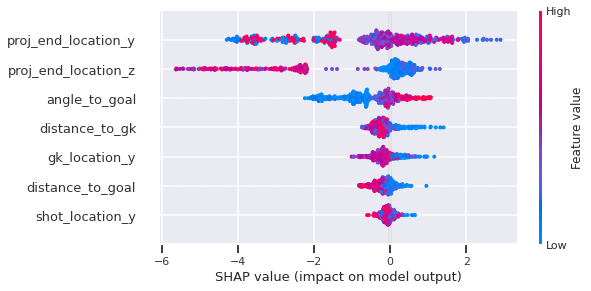

In [76]:
import shap
shap.initjs() 
explainer = shap.Explainer(xgb_best, X_train_os, feature_names=X.columns)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

-	High values of end_position_ext_z makes the probability decrease a lot. It is because it is taking the shots where the players shot above of the goal posts. We see that there is also cluster of red points when the SHAP values is high indicating that shots with big z (without being more than the 2.67 of the goal post), bigger is the probability. 
-	We clearly see that as bigger is the angle, bigger is the probability of scoring.
-	In the distances features we see that as less distance there is, more probability of goal.


#Conclusions

In [77]:
def generate_end_y():
    my_list = list(range(363, 439, 2)) #len of 38
    lst = [x / 10 for x in my_list]
    return (lst)*25

def generate_end_z():
  my_list = list(range(0, 25, 1)) #len of 25
  lst = [x / 10 for x in my_list]
  result = []
  for num in lst:
      result += [num]*38
  return(result)

In [78]:
def produce_3x5_matrix(proba_matrix):
  new_rows = 3
  new_cols = 5

  # Calculate the number of rows and columns to combine
  row_step = proba_matrix.shape[0] // new_rows
  col_step = proba_matrix.shape[1] // new_cols

  # Calculate the new matrix by taking the average of nearby values
  new_matrix = np.zeros((new_rows, new_cols))
  for i in range(new_rows):
      for j in range(new_cols):
          row_start = i * row_step
          row_end = (i + 1) * row_step
          col_start = j * col_step
          col_end = (j + 1) * col_step
          new_matrix[i, j] = round(np.mean(proba_matrix[row_start:row_end, col_start:col_end])*100,2)

  return new_matrix

In [79]:
def shot_probability(location_x, location_y, gk_y, gk_x):
  matrix_3x5_list = []
  gk_pos = np.array([120-gk_x, gk_y]) #Goalkeeper is on mean 2.5 meters above the goal line
  for i in range(-10, 11, 5):
    for j in range(-10, 11, 5):
      shot_location = np.array([location_x+(i/10), location_y+(j/10)])
      dist_to_goal = distance_to_goal(shot_location)
      angle = angle_to_goal(shot_location)
      dis_to_gk = distance_to_gk(shot_location, gk_pos)

      shot_location_x = [location_x+(i/10)]*950 #25*38 that are the number of rows*columns 
      shot_location_y = [location_y+(j/10)]*950
      angle_to_g = [angle]*950
      gk_location_y = [gk_y]*950
      dist_to_gk = [dis_to_gk]*950
      proj_end_location_y = generate_end_y()
      proj_end_location_z = 	generate_end_z()

      X_df = pd.DataFrame({
      #'shot_location_x': shot_location_x,
      'shot_location_y': shot_location_y,
      'gk_location_y': gk_location_y,
      'distance_to_goal': dist_to_goal,
      'angle_to_goal': angle_to_g,
      'distance_to_gk': dist_to_gk,
      'proj_end_location_y': proj_end_location_y,
      'proj_end_location_z': proj_end_location_z
      })
      X_df_sca = scaler.transform(X_df) #Scale our X_train

      xgb_probability_df = 1 / (1 + np.exp(-xgb_best.predict_proba(X_df_sca)))
      proba_list = xgb_probability_df[:,1]
      proba_list = [round(num, 2) for num in proba_list]
      proba_matrix = np.array(proba_list).reshape((25,38))
      matrix_3x5 = produce_3x5_matrix(proba_matrix)
      matrix_3x5_list.append(matrix_3x5)
  stacked_matrices = np.stack(matrix_3x5_list)
  mean_matrix = np.mean(stacked_matrices, axis=0)
  mean_matrix = np.round(mean_matrix,2)
  return mean_matrix

In [80]:
proba_matrix = shot_probability(108, 39, 40, 4)
print(proba_matrix)

[[94.55 66.26 54.56 73.52 85.4 ]
 [94.26 59.22 42.56 59.28 75.57]
 [92.51 53.33 36.92 54.81 72.81]]


#Visualization

##Installs

In [81]:
!pip install ipycanvas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.7/255.7 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.6 MB/s eta 0:00:00


In [82]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 27.0 MB/s eta 0:00:00


##Imports

In [84]:
from PIL import Image, ImageDraw
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patheffects as patheffects
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from google.colab import output, drive
import ipywidgets as widgets
from ipywidgets import Dropdown, Button, interact, IntSlider
from IPython.display import display
import numpy as np
output.enable_custom_widget_manager()

# Montar el disco de Google Drive
drive.mount('/content/drive')

%matplotlib ipympl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
%matplotlib ipympl
mpl.rcParams['figure.facecolor'] = 'none'

##Code

BoundedFloatText(value=2.5, description='Meters In Front Of The Goal (GK):', max=5.0, step=0.5, style=Descript…

interactive(children=(IntSlider(value=0, continuous_update=False, description='Goalkeeper Position', max=122, …

Button(description='Set Goalkeeper To Center', layout=Layout(width='auto'), style=ButtonStyle())

Text(value='', description='Football Pitch Coordinates:', disabled=True, style=DescriptionStyle(description_wi…

Button(description='Update Goal Heatmap', layout=Layout(width='auto'), style=ButtonStyle())

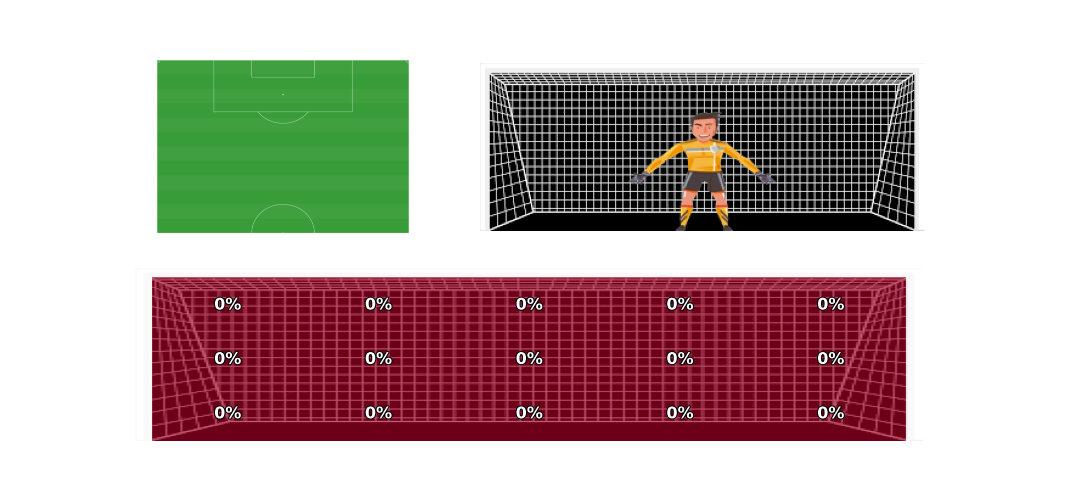

In [86]:
  # Definir las coordenadas máximas de la imagen
MAX_X, MAX_Y = 80, 55 #The max Y is set to 55 to adjust the image

# Cargar la imagen desde la ruta del archivo
img_path = "/content/drive/My Drive/SPORTSANALYTICS/PROYECTO/assets/half-rotate.jpg"
img = Image.open(img_path)

# Crear una figura con dos subplots en la misma fila
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1.5] })

# create a GridSpec with 2 rows and 2 columns
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1.5, 0])

# create the first two subplots in the first row
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

# create the third subplot in the second row, spanning both columns
ax3 = plt.subplot(gs[1, :2])

#Text Box of the number of players in the angle between posts of the shots
NumMetersGoalkeeper = widgets.BoundedFloatText(
    value=2.5,
    min=0,
    max=5,
    step=0.5,
    description='Meters In Front Of The Goal (GK):',
    style= {'description_width': 'initial'}
)
 # Function to capture the change the meters that the goalkeeper is from the goal line
gk_meters = 2.5
def update_NumMetersGoalkeeper(change):
    global gk_meters
    gk_meters = NumMetersGoalkeeper.value

NumMetersGoalkeeper.observe(update_NumMetersGoalkeeper, names='value')
display(NumMetersGoalkeeper)

# Ajustar la imagen al tamaño de la ventana de la gráfica y mostrarla en el primer subplot
ax1.imshow(img, extent=[0, MAX_X, 0, MAX_Y])
ax1.invert_yaxis()
ax1.set_title('Football Pitch', color='white')
ax1.axis('off')

# Crear un widget de texto para mostrar las coordenadas
coordenadas = widgets.Text(description='Football Pitch Coordinates:', disabled=True,style= {'description_width': 'initial'})

# Crear una variable global para almacenar el objeto del círculo actual
circulo_actual = None

# Crear una función que dibuje un círculo en las coordenadas dadas
def dibujar_circulo(x, y):
    global circulo_actual
    # Eliminar el círculo anterior si existe
    if circulo_actual:
        circulo_actual.remove()
    # Crear un nuevo círculo
    circulo = Circle((x, y), 1, color='r', fill=False, linewidth=2)
    # Asignar el nuevo círculo a la variable global
    circulo_actual = circulo
    # Agregar el nuevo círculo al objeto Axes
    ax1.add_patch(circulo)

x_field = 0
y_field = 0
# Crear una función que obtenga las coordenadas x y de un clic en la imagen
def obtener_coordenadas(event):
    global x_field, y_field
    if event.inaxes is not None:
        x_field, y_field = round(event.xdata,2), round(event.ydata,2)
        coordenadas.value = f'({x_field:.2f}, {y_field:.2f})'
        dibujar_circulo(x_field, y_field)
        fig.canvas.draw()

# Conectar la función 'obtener_coordenadas' con la figura
cid = fig.canvas.mpl_connect('button_press_event', obtener_coordenadas)

# Cargar los datos para el mapa de calor
#heatmap_data = [[0, 0.1, 0.2, 0.3, 0.4, 0.5], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], [0.2, 0.3, 0.4, 0.5, 0.6, 0.7], [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]]
heatmap_data = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]

# Mostrar el mapa de calor en el objeto Axes recién creado
def print_goal_heatmap(heatmap_data):
    global heatmap
    heatmap = ax3.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', zorder=1, extent=[0, len(heatmap_data[0]), len(heatmap_data), 0])
    heatmap.set_clim(vmin=0, vmax=100)

print_goal_heatmap(heatmap_data)

# Cargar la imagen y mostrarla en la esquina superior derecha del mapa de calor
img_goal = mpimg.imread('/content/drive/My Drive/SPORTSANALYTICS/PROYECTO/assets/goal_posts.jpg')
ax3.imshow(img_goal, extent=[-0.115,5.11,0,3.18], aspect='auto', zorder=2, alpha=0.35)

# Mostrar los valores en cada celda del mapa de calor
def print_heatmap_data(heatmap_data):  
    for text in ax3.texts:
        text.set_text("")  
    for i in range(len(heatmap_data)):
        for j in range(len(heatmap_data[0])):
            text = ax3.text(j+0.5, i+0.5, f"{heatmap_data[i][j]}%", ha='center', va='center', color='white', fontsize=16, weight='bold', path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

print_heatmap_data(heatmap_data)

# Ocultar zoom, header y footer
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

# Añadir título portería
ax3.set_title('Goal Post Shot Probability', color='white')

# Ocultar los ejes y la leyenda
ax3.axis('off')

# Load the goal and goalkeeper images
goal_image = Image.open('/content/drive/My Drive/SPORTSANALYTICS/PROYECTO/assets/goal_posts.jpg')
goalkeeper_image = Image.open('/content/drive/My Drive/SPORTSANALYTICS/PROYECTO/assets/goalkeeper.png')

# Scale the goalkeeper image to be inside the goal
goalkeeper_image = goalkeeper_image.resize((int((goal_image.width/3)), int((goal_image.height/7)*5)))

# Create a new image with alpha channel and paste the goalkeeper image onto it
goalkeeper_with_alpha = Image.new('RGBA', goal_image.size, (0, 0, 0, 0))
mask = goalkeeper_image.convert('RGBA').split()[-1]
goalkeeper_with_alpha.paste(goalkeeper_image, (int((goal_image.width/2)- goalkeeper_image.width/2), int((goal_image.height)- goalkeeper_image.height)), mask=mask)

x_goalkeeper = 0
# Define a function to update the goalkeeper's position
def update_goalkeeper_position(x):
    global goalkeeper_with_alpha
    global goal_image
    global x_goalkeeper
    x_goalkeeper = round(x/32,2)
    goal_copy = goal_image.copy().convert('RGBA')
    goal_copy.paste(goalkeeper_with_alpha, (x, 0), mask=goalkeeper_with_alpha)
    ax2.imshow(goal_copy)

# Define the slider to adjust the x-position of the goalkeeper
slider = IntSlider(description='Goalkeeper Position',style= {'description_width': 'initial'},
                  min=-(goal_image.width/2 - goalkeeper_image.width/2),
                  max=(goal_image.width/2 - goalkeeper_image.width/2),
                  readout=False, continuous_update=False, value=0)
interact(update_goalkeeper_position, x=slider);

# def update_slider_label(change):
#     slider.description = 'Goalkeeper Position ({:.2f})'.format(change.new/32)

# slider.observe(update_slider_label, 'value')

# Define a function to update the slider value to 0
def update_slider_to_zero(button_center_goalkeeper):
    slider.value = 0

# Create the button widget
button_center_goalkeeper = Button(description='Set Goalkeeper To Center')
button_center_goalkeeper.layout.width = 'auto'

# Attach the update_slider_to_zero function to the button's on_click event
button_center_goalkeeper.on_click(update_slider_to_zero)

# Display the button and slider widgets
display(button_center_goalkeeper)

# Añadir título portería
ax2.set_title('Goalkeeper Position', color='white')

# Ocultar los ejes y la leyenda
ax2.axis('off')

#Mostrar las coordenadas seleccionadas
display(coordenadas)

# Define a function to call the matrix
def update_goal_matrix(button_update_matrix):
    if x_field == 0 and y_field == 0:
      print('You need to select at least one coordinate in the pitch')
    else:
      heatmap_data = shot_probability(round(120-y_field,2), x_field, round(40+x_goalkeeper*-1,2), gk_meters)
      heatmap.set_data(heatmap_data)
      print_heatmap_data(heatmap_data)
      fig.canvas.draw_idle()
      #print(round(120-y_field,2),'-',x_field,'-',round(40+x_goalkeeper*-1,2), gk_meters)
      #print(heatmap_data)

# Create the button widget
button_update_matrix = Button(description='Update Goal Heatmap')
button_update_matrix.layout.width = 'auto'

# Attach the update_goal_matrix function to the button's on_click event
button_update_matrix.on_click(update_goal_matrix)

# Display the button and slider widgets
display(button_update_matrix)

# Mostrar la figura con las dos subplots
plt.show()

# Goalkeepers, players and teams evaluation

In [87]:
selected_data = extracted_data.loc[X_test_df.index] #From the original dataframe, the ones that has been used for X_test
selected_data['PSxG'] = xgb_test_probability[:,1]
player_team_df = selected_data[['gk', 'player','team','goal','PSxG', 'shot_statsbomb_xg']]

# Calculate the difference between PSxG and actual goals
player_team_df['PSxG_difference'] = player_team_df['goal'] - player_team_df['PSxG']
player_team_df['PSxG'] = player_team_df['PSxG'].round(2)
player_team_df['PSxG_difference'] = player_team_df['PSxG_difference'].round(2)
player_team_df['shot_statsbomb_xg'] = player_team_df['shot_statsbomb_xg'].round(2)
player_team_df = player_team_df.assign(shot_statsbomb_xg=player_team_df.pop('shot_statsbomb_xg'))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Goalkeepers

In [88]:
gk_df = player_team_df.groupby(['gk']).sum()
gk_df['Shots_received'] = player_team_df.groupby(['gk']).size().values

In [89]:
gk_df = gk_df.sort_values(by = ['PSxG'],
                                  ascending=False)
gk_df.head(10)

,goal,PSxG,PSxG_difference,shot_statsbomb_xg,Shots_received
gk,,,,,
Kasper Schmeichel,2,5.76,-3.76,1.64,17
Dominik Livaković,2,5.26,-3.26,2.76,19
Manuel Neuer,2,3.37,-1.37,1.47,11
Vladimir Stojković,2,3.37,-1.37,1.13,11
Jordan Pickford,2,3.22,-1.22,2.36,17
Lawrence Ati-Zigi,4,3.19,0.81,2.18,11
Shūichi Gonda,2,3.15,-1.15,1.08,9
Vanja Milinković Savić,2,2.98,-0.98,1.96,8
Yann Sommer,0,2.96,-2.96,0.68,13


In [95]:
gk_df = gk_df.sort_values(by = ['PSxG_difference'],
                                  ascending=False)
gk_df.head(10)

,goal,PSxG,PSxG_difference,shot_statsbomb_xg,Shots_received
gk,,,,,
Lawrence Ati-Zigi,4,3.19,0.81,2.18,11
Wojciech Szczęsny,3,2.25,0.75,1.88,14
Danny Ward,1,0.31,0.69,0.05,2
Alisson Ramsés Becker,3,2.33,0.67,0.73,13
Néstor Fernando Muslera Micol,1,0.47,0.53,0.36,10
David de Gea Quintana,1,0.64,0.36,0.07,2
Ederson Santana de Moraes,1,0.72,0.28,0.06,1
Keylor Navas Gamboa,3,2.77,0.23,1.31,10
Francis Odinaka Uzoho,1,0.83,0.17,0.66,6


Players

In [91]:
player_df = player_team_df.groupby(['player']).sum()
player_df['Shots_done'] = player_team_df.groupby(['player']).size().values
player_df = player_df.sort_values(by = ['PSxG'],
                                  ascending=False)
player_df.head(10)

,goal,PSxG,PSxG_difference,shot_statsbomb_xg,Shots_done
player,,,,,
Kylian Mbappé Lottin,4,2.61,1.39,1.36,9
Giorgian Daniel De Arrascaeta Benedetti,2,2.40,-0.40,1.14,3
Mathew Leckie,1,1.94,-0.94,0.31,4
Ahmed Musa,2,1.91,0.09,0.72,3
Neymar da Silva Santos Junior,1,1.91,-0.91,1.33,9
José Paolo Guerrero Gonzáles,0,1.76,-1.76,0.28,3
Romelu Lukaku Menama,1,1.71,-0.71,1.57,7
Memphis Depay,1,1.55,-0.55,0.61,4
Ivan Perišić,1,1.54,-0.54,0.41,8


In [92]:
player_df = player_df.sort_values(by = ['PSxG_difference'],
                                  ascending=True)

player_df.head(10)

,goal,PSxG,PSxG_difference,shot_statsbomb_xg,Shots_done
player,,,,,
José Paolo Guerrero Gonzáles,0,1.76,-1.76,0.28,3
Vinícius José Paixão de Oliveira Júnior,0,1.51,-1.51,0.32,4
Younès Belhanda,0,1.39,-1.39,0.12,3
Joshua Kimmich,0,1.18,-1.18,0.20,3
Lionel Andrés Messi Cuccittini,0,1.16,-1.16,0.26,5
Ante Rebić,0,1.00,-1.00,0.35,3
Gleison Bremer Silva Nascimento,0,0.99,-0.99,0.34,1
Jawad El Yamiq,0,0.97,-0.97,0.06,1
Cristian Gabriel Rodríguez Barrotti,0,0.95,-0.95,0.02,1


Teams

In [93]:
team_df = player_team_df.groupby(['team']).sum()
team_df['Shots_done'] = player_team_df.groupby(['team']).size().values
team_df = team_df.sort_values(by = ['PSxG'],
                                  ascending=False)

team_df.head(10)

,goal,PSxG,PSxG_difference,shot_statsbomb_xg,Shots_done
team,,,,,
Brazil,4,11.02,-7.02,4.48,32
Croatia,5,7.92,-2.92,3.24,38
Belgium,4,6.50,-2.50,2.43,23
Germany,4,6.26,-2.26,2.25,18
France,6,4.92,1.08,3.69,31
South Korea,5,4.71,0.29,1.28,13
Mexico,2,4.36,-2.36,1.35,20
Spain,3,4.23,-1.23,1.60,16
Uruguay,3,4.05,-1.05,2.38,17


In [94]:
team_df = team_df.sort_values(by = ['PSxG_difference'],
                                  ascending=True)

team_df.head(10)

,goal,PSxG,PSxG_difference,shot_statsbomb_xg,Shots_done
team,,,,,
Brazil,4,11.02,-7.02,4.48,32
Peru,0,2.97,-2.97,0.48,7
Croatia,5,7.92,-2.92,3.24,38
Belgium,4,6.50,-2.50,2.43,23
Mexico,2,4.36,-2.36,1.35,20
Germany,4,6.26,-2.26,2.25,18
Argentina,1,3.09,-2.09,1.42,17
Morocco,2,3.80,-1.80,1.11,20
Sweden,0,1.77,-1.77,0.71,7
